<a href="https://colab.research.google.com/github/IANovoselov/well/blob/main/well.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [349]:
import numpy as np
import pandas as pd

In [350]:
 # Исходные данные для моделировния

# Фонтанирующая скважина
# p_R = 28  # Среднепластовое давление
# p_G0 = 25  # Давление насыщенного газа

# Нефонтанирующая скважина
p_R = 21.65  # Среднепластовое давление
p_G0 = 17.32  # Давление насыщенного газа

H_R = 3000  # Глубина забоя по вертикали
w_1 = 12  # Гидропроводность из пласта в ПЗ скважины
w_2 = 60  # Гидропроводность из ПЗ в забой
betta = 0.3  # Объёмная доля воды
p_0 = 0.1  # Атмосферное давление

# Удельный вес
gamma_oil = 0.0068  # нефти
gamma_water = 0.011  # воды
gamma_gas = 0.000008  # газа
G = 100  # Газовый фактор
p_L = 1.5  # Давление в линии нефтесбора

# Гидросопротивление
r_K = 0.5  # обсадной колонный
r_N = 4  # НКТ
r_T = 0.8  # затрубного пространства
r_U = 3  # устьевого штуцера
r_GU = 3  # перепускного клапана

# Параметры насоса
H_N = 2000  # уровень подвеса
q_0 = 60  # номинальный дебит

# Напорная характеристика
q_Pump = [5/3, 4/3, 2/3]
lambda_0 = [10/3, 2, 3/2]
lambda_1 = [2, 1, 1/4]
lambda_2 = [0.5, 0.82, 0.74]
lambda_3 = [0.42, 0.18, 0.3]

In [351]:
# Моделируемые данные, начальные условия
_q_N = []
_q_T = []
__q = []
_p_1 = []
_p_2 = []
_p_3 = []
_p_5 = []
_p_4 = []
_p_8 = []
_u = []
_h_4 = []
_betta_G3 = []
_betta_GN = []
_N_1 = []
_N_2 = []
_count = []
_n_NN = []

In [352]:
# Статический расчёт скважины

# Гидросопротивления
r_1 = 1/w_1  # Пласт - ПЗ
r_2 = 1/w_2  # ПЗ - забой
r_R = r_1 + r_2
r_1 = 0.083
r_2 = 0.017
r_R = 0.1

In [353]:
# Ограничения
h_lim = 100  # По уровню над приёмом насос
betta_G_lim = 0.25  # По газу у первой ступени

In [354]:
# Высота столба жидкости
gamma = (1-betta)*gamma_oil+betta*gamma_water
dH_R =  (p_R-p_L)/gamma - H_R
dH_R

-500.0

In [355]:
h_0 = q_0*(r_U + r_N + r_K + r_R/gamma) - dH_R
h_0 = 1700

In [356]:
alpha_G_3 = 0.4
alpha_betta = 0.333
k_S = 0.7
X_G = 0.00008

M_R3 = (1-betta)*G*((alpha_G_3*p_0) / (p_G0 - p_0))
M_R3 = 0.16
p_G3 = p_G0 * (((1-k_S)*M_R3)/(((1-k_S)*M_R3)+alpha_betta))

a_GU = 0.0000091 #k_S*X_G*M_R3

In [357]:
# Расчёт динамики

# Начальные условия

M_q = 0.5

h_4 = H_N + dH_R
p_2 = p_R
t = 0
w = 1
q = 0
p_3 = p_L + gamma * h_4
epsilon = 0.00001 * p_3
q_L = 0

# Сегмент напорной характеристики
i = 1
k = 35000
dt = 0.0001


In [358]:
# Статика при вариации частоты
_N_1 = []
_N_2 = []
_count = []
_n_NN = []

# _w = np.linspace(0.8, 1.2, 5000)
# for w in _w:
#     q_N = (w*w*h_0*lambda_0[i] - H_R + (1/gamma)*(p_R - p_L)) / (w*(h_0/q_0)*lambda_1[i]+r_U+r_N+r_K+(r_R/gamma))


#     h_N = h_0*(w*w*lambda_0[i]-w*lambda_1[i]*(q_N/q_0))

#     n_N = 0.5
#     N_1_0 = (gamma*h_0*q_0)/n_N
#     N_2 = gamma * h_N * q_N

#     alpha_n_L =0.4
#     alpha_n_R =0.28
#     w_n_L = 0.96
#     w_n_R = 1.04
#     delta_n_N = alpha_n_L * max(w_n_L-w, 0) + alpha_n_R * max(w-w_n_R, 0)

#     N_1 = N_1_0*(1+delta_n_N)*(w*w*w*lambda_2[i] + w*w*lambda_3[i]*(q_N/q_0))

#     n_NN = N_2/N_1

#     count = N_1/q_N

#     _u.append(w)
#     _q_N.append(q_N)
#     _N_1.append(N_1)
#     _N_2.append(N_2)
#     _count.append(count)
#     _n_NN.append(n_NN)

In [359]:
# df = pd.DataFrame({'q_N': _q_N,  'u': _u,  'N_1': _N_1,  'N_2': _N_2,  'count': _count,  'n_NN': _n_NN})

In [360]:
# from matplotlib import pyplot as plt
# fig, ax = plt.subplots(figsize=(10, 5))
# fig.subplots_adjust(right=0.75)

# twin1 = ax.twinx()

# p1, = ax.plot(df['u'],  df['N_1'],'k--', lw=2, label="N1")
# p2, = ax.plot(df['u'],  df['N_2'],'k-.', lw=2, label="N2")
# p3, = twin1.plot(df['u'], df['n_NN'],'k', lw=2, label="n")

# twin1.set(ylim=(0.46, 0.56))

# ax.legend(handles=[p1, p2, p3])

# ax.grid()

# plt.show()


In [361]:
# from matplotlib import pyplot as plt
# fig, ax = plt.subplots(figsize=(10, 5))
# fig.subplots_adjust(right=0.75)

# twin1 = ax.twinx()

# p1, = ax.plot(df['u'],  df['q_N'],'k--', lw=2, label="q_N")
# p2, = twin1.plot(df['u'],  df['count'],'k', lw=2, label="count")

# ax.set(ylim=(30, 140))
# twin1.set(ylim=(30, 140))

# ax.legend(handles=[p1, p2])

# ax.grid()

# plt.show()

In [362]:

# Начало расчёта
for _k in range(k):
    q = (p_2 - p_3 - gamma*(H_R-H_N)) / (r_1 + gamma * r_K)
    p_4 = (p_L + (p_G0 - p_3) * r_GU * np.sqrt(w) * a_GU * q)
    __p_3 = p_4 + gamma * h_4
    # Балансировка притока по начальным условиям
    while abs(p_3 - __p_3) > epsilon:
        p_3 = (1-M_q)*p_3 + M_q*__p_3
        q = (p_2 - p_3 - gamma*(H_R-H_N)) / (r_1 + gamma * r_K)
        p_4 = (p_L + (p_G0 - p_3) * r_GU * np.sqrt(w) * a_GU * q)
        __p_3 = p_4 + gamma * h_4
    p_3 = __p_3
    p_8 =p_L + gamma*r_U*q_L

    # Расчёт подачи

    q_N = (w*w*h_0*lambda_0[i] - H_N + (1/gamma)*(p_3 - p_8)) / (w*(h_0/q_0)*lambda_1[i]+r_N)
    q_N = max(q_N, 0)

    if  q_N > w*q_0*q_Pump[i]:
      i-=1
      i = max(i, 0)
      q_N = (w*w*h_0*lambda_0[i] - H_N + (1/gamma)*(p_3 - p_8)) / (w*(h_0/q_0)*lambda_1[i]+r_N)
      q_N = max(q_N, 0)

    if  q_N < w*q_0*q_Pump[i+1]:
      i+=1
      q_N = (w*w*h_0*lambda_0[i] - H_N + (1/gamma)*(p_3 - p_8)) / (w*(h_0/q_0)*lambda_1[i]+r_N)
      q_N = max(q_N, 0)



    betta_G3 = (M_R3*(p_G0 - p_3)) / (p_3 + M_R3*(p_G0 - p_3))
    M_RS = (1 - k_S*np.sqrt(w))* M_R3
    betta_GN = (M_RS*(p_G0 - p_3)) / (p_3 + M_RS*(p_G0 - p_3))


    p_1 = p_2 - r_1*q
    p_5 = p_8 + gamma*(H_N+r_N*q_N)


    h_N = h_0*(w*w*lambda_0[i]-w*lambda_1[i]*(q_N/q_0))
    n_N = 0.5
    N_1_0 = (gamma*h_0*q_0)/n_N
    N_2 = gamma * h_N * q_N
    alpha_n_L =0.1
    alpha_n_R =0.07
    w_n_L = 0.96
    w_n_R = 1.04
    delta_n_N = alpha_n_L * max(w_n_L-w, 0) + alpha_n_R * max(w-w_n_R, 0)
    N_1 = N_1_0*(1+delta_n_N)*(w*w*w*lambda_2[i] + w*w*lambda_3[i]*(q_N/q_0))
    n_NN = N_2/N_1

    _p_1.append(p_1)
    _p_3.append(p_3)
    _p_4.append(p_4)
    _p_8.append(p_8)
    _q_N.append(q_N)
    __q.append(q)
    _h_4.append(h_4)
    _u.append(w)
    _p_5.append(p_5)
    _N_1.append(N_1)
    _N_2.append(N_2)
    _n_NN.append(n_NN)
    _betta_G3.append(betta_G3)
    _betta_GN.append(betta_GN)

    # Шаг по Эйлеру
    p_2 = p_2 + (dt/0.4)*(p_R - p_2 - r_2*q)
    h_4 = h_4 + (dt/0.01)*(q-q_N)
    q_L = q_L + (dt/0.001)*(q_N-q_L)



In [363]:

x = np.linspace(0, k*dt, k)
x

array([0.00000000e+00, 1.00002857e-04, 2.00005714e-04, ...,
       3.49979999e+00, 3.49990000e+00, 3.50000000e+00])

In [364]:
df = pd.DataFrame({'q_N': _q_N, 'p_3': _p_3, 'p_1': _p_1, 'q': __q, 'h_4': _h_4, 'u': _u, 'x': x,
                   'p_4': _p_4, 'p_8': _p_8, 'p_5': _p_5, 'N_1': _N_1, 'N_2': _N_2, 'n_NN': _n_NN,
                   'betta_G3': _betta_G3, 'betta_GN': _betta_GN})

In [365]:
df

,q_N,p_3,p_1,q,h_4,u,x,p_4,p_8,p_5,N_1,N_2,n_NN,betta_G3,betta_GN
0,85.164835,13.590000,21.650000,0.000000,1500.000000,1,0.0000,1.500000,1.500000,20.365714,1802.340000,577.052590,0.320169,0.042067,0.013003
1,84.729668,13.583144,21.643563,0.077558,1499.148352,1,0.0001,1.500008,1.705929,20.557613,1797.331370,590.944484,0.328790,0.042162,0.013033
2,84.338853,13.576329,21.637063,0.155867,1498.301831,1,0.0002,1.500016,1.890212,20.729297,1792.833207,603.273113,0.336491,0.042256,0.013063
3,83.987735,13.569552,21.630599,0.233738,1497.460001,1,0.0003,1.500024,2.055122,20.882887,1788.791952,614.230460,0.343377,0.042349,0.013093
4,83.672150,13.562809,21.624168,0.311207,1496.622461,1,0.0004,1.500032,2.202692,21.020282,1785.159669,623.982837,0.349539,0.042442,0.013123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34995,60.116387,7.336346,15.638612,60.115807,722.079496,1,3.4996,1.516385,2.953614,21.011767,1644.814105,822.116907,0.499824,0.178804,0.061316
34996,60.116387,7.336345,15.638612,60.115807,722.079490,1,3.4997,1.516385,2.953614,21.011767,1644.814104,822.116907,0.499824,0.178804,0.061316
34997,60.116387,7.336345,15.638612,60.115807,722.079485,1,3.4998,1.516385,2.953614,21.011767,1644.814103,822.116907,0.499824,0.178804,0.061316
34998,60.116387,7.336345,15.638612,60.115807,722.079479,1,3.4999,1.516385,2.953614,21.011767,1644.814102,822.116907,0.499824,0.178804,0.061316


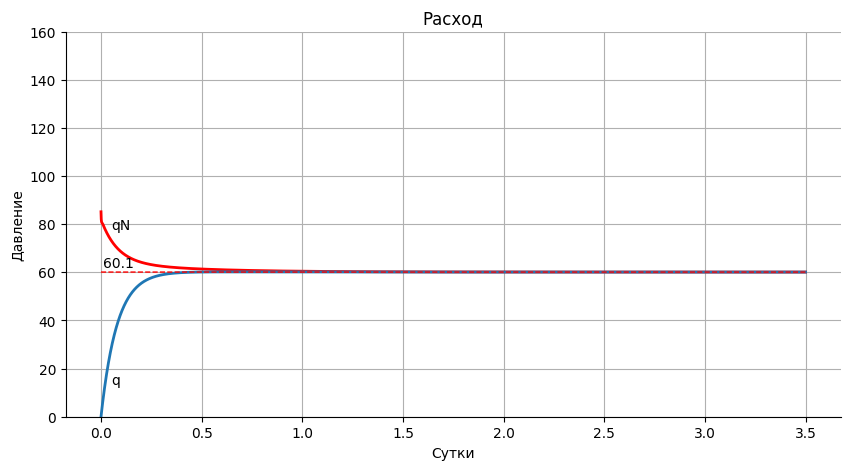

In [366]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.gca().spines[['top', 'right']].set_visible(False)
# plot one by one

plt.plot(df['x'], df['q_N'], 'r', lw=2)
plt.plot(df['x'], df['q'], lw=2)
plt.plot(df['x'], [df['q'][k-1]]*k,'r--', lw=1)


# set x label
plt.xlabel('Сутки')
plt.ylabel('Давление')

# set title
plt.title('Расход')


plt.ylim(0, 160)
plt.grid(True)

plt.annotate('q', xy = (df['x'][500],df['q'][200] ))
plt.annotate('qN', xy = (df['x'][500],df['q_N'][200] ))
plt.annotate(df['q_N'][k-1].round(1), xy = (df['x'][100], df['q_N'][k-1]*1.03 ))
# display plot
plt.show()


In [367]:
df['q_N']

,q_N
0,85.164835
1,84.729668
2,84.338853
3,83.987735
4,83.672150
...,...
34995,60.116387
34996,60.116387
34997,60.116387
34998,60.116387


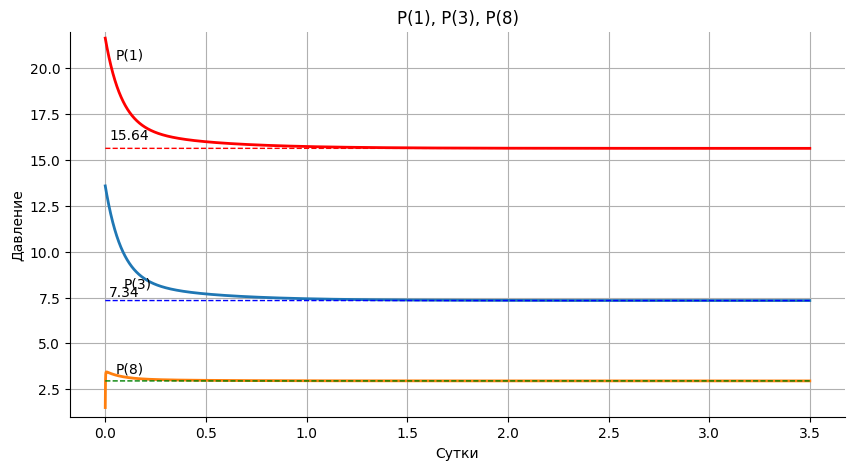

In [368]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 5))
plt.gca().spines[['top', 'right']].set_visible(False)
# plot one by one


plt.plot(df['x'], df['p_1'],'r', lw=2)
plt.plot(df['x'], [df['p_1'][k-1]]*k,'r--', lw=1)

plt.plot(df['x'], df['p_3'], lw=2)
plt.plot(df['x'], [df['p_3'][k-1]]*k,'b--', lw=1)

plt.plot(df['x'], df['p_8'], lw=2)
plt.plot(df['x'], [df['p_8'][k-1]]*k,'g--', lw=1)


# set x label
plt.xlabel('Сутки')
plt.ylabel('Давление')

# set title
plt.title('P(1), P(3), P(8)')


plt.ylim(1, 22)
plt.grid(True)
plt.annotate('P(1)', xy = (df['x'][500],df['p_1'][200] ))
plt.annotate(str(df['p_1'][k-1].round(2)), xy = (df['x'][200], df['p_1'][k-1]*1.03))

plt.annotate('P(3)', xy = (df['x'][900],8 ))
plt.annotate(str(df['p_3'][k-1].round(2)), xy = (df['x'][200], df['p_3'][k-1]*1.03))


plt.annotate('P(8)', xy = (df['x'][500],df['p_8'][200] ))
#plt.annotate(str(df['p_8'][14999].round(2)), xy = (df['x'][200], df['p_8'][14999]*1.03))

# display plot
plt.show()

In [369]:
str(df['p_1'][k-1].round(2))

'15.64'

In [370]:
df.iloc[14999]

,14999
q_N,60.215465
p_3,7.364568
p_1,15.666885
q,60.126658
h_4,725.586387
u,1.000000
x,1.499943
p_4,1.516341
p_8,2.956016
p_5,21.017363


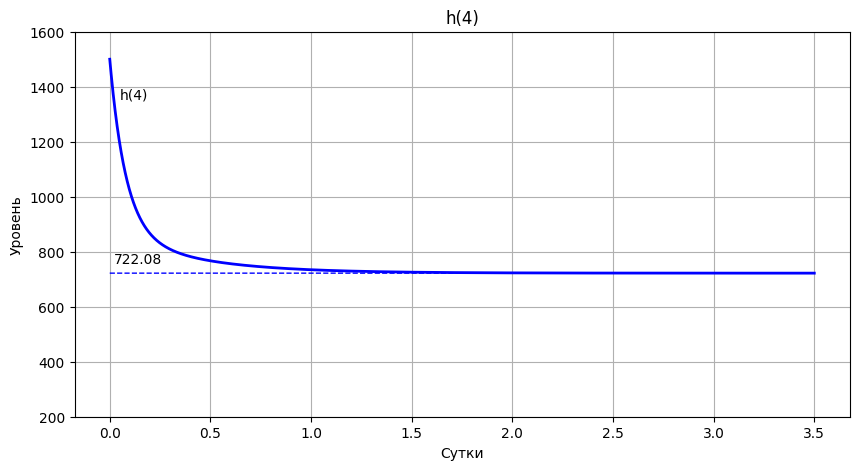

In [371]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 5))

plt.plot(df['x'], df['h_4'],'b', lw=2)
plt.plot(df['x'], [df['h_4'][k-1]]*k,'b--', lw=1)

plt.annotate('h(4)', xy = (df['x'][500],df['h_4'][200] ))
plt.annotate(str(df['h_4'][k-1].round(2)), xy = (df['x'][200], df['h_4'][k-1]*1.05))

# set x label
plt.xlabel('Сутки')
plt.ylabel('Уровень')

# set title
plt.title('h(4)')
plt.ylim(200, 1600)
plt.grid(True)
plt.show()